#Training the Model

#Loading Libraries and Dataset

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
import os

In [ ]:
import librosa as lb

In [ ]:
import sys
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Loading Dataset
files_df=pd.read_csv("/content/drive/MyDrive/Mosaic23/file_info.csv")

In [ ]:
files_df.head()

,start,end,crackles,weezels,pid,mode,filename
0,1.5629,3.4694,0.0,1.0,195,sc,195_1b1_Ar_sc_Litt3200_0.wav
1,3.4694,5.4677,0.0,0.0,195,sc,195_1b1_Ar_sc_Litt3200_1.wav
2,5.4677,7.5242,0.0,1.0,195,sc,195_1b1_Ar_sc_Litt3200_2.wav
3,7.5242,9.8468,0.0,0.0,195,sc,195_1b1_Ar_sc_Litt3200_3.wav
4,9.8468,11.1340,0.0,0.0,195,sc,195_1b1_Ar_sc_Litt3200_4.wav


Playing with various spectral Features

[Text(0.5, 1.0, 'MFCC')]

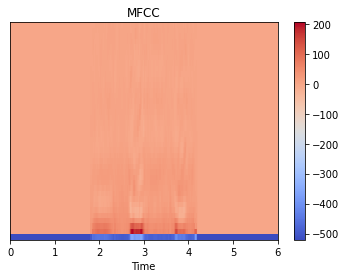

In [ ]:
path='/content/drive/MyDrive/Mosaic23/processed_audio_files/'

import librosa.display
file=path +files_df.iloc[3].filename
sound,sample_rate=lb.load(file)
mfccs = lb.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40)
fig, ax = plt.subplots()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

In [ ]:
S = np.abs(librosa.stft(y=sound))
S

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

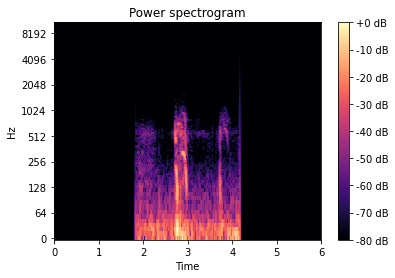

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S,
                                                        ref=np.max),
                                y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

Adding a column for final outcome which will later be label encoded

In [ ]:
files_df['weezels'] = files_df['weezels'].astype(int)
files_df['crackles'] = files_df['crackles'].astype(int)

In [ ]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6110 entries, 0 to 6109
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     6110 non-null   float64
 1   end       6110 non-null   float64
 2   crackles  6110 non-null   int64  
 3   weezels   6110 non-null   int64  
 4   pid       6110 non-null   int64  
 5   mode      6110 non-null   object 
 6   filename  6110 non-null   object 
dtypes: float64(2), int64(3), object(2)
memory usage: 334.3+ KB


In [ ]:
def categorise(row):
  if row['weezels']==0 and row['crackles']==0 :
    return 'normal'
  elif row['weezels']==1 and row['crackles']==0 :
    return 'weezels'
  elif row['weezels']==0 and row['crackles']==1 :
    return 'crackles'
  else:
    return 'both'

In [ ]:
files_df['outcome'] = files_df.apply(lambda row: categorise(row), axis=1)

In [ ]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6110 entries, 0 to 6109
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     6110 non-null   float64
 1   end       6110 non-null   float64
 2   crackles  6110 non-null   int64  
 3   weezels   6110 non-null   int64  
 4   pid       6110 non-null   int64  
 5   mode      6110 non-null   object 
 6   filename  6110 non-null   object 
 7   outcome   6110 non-null   object 
dtypes: float64(2), int64(3), object(3)
memory usage: 382.0+ KB


Dividing the data into train and testing(validation datset)

In [ ]:
from sklearn.model_selection import train_test_split
Xtrain,Xval,ytrain,yval=train_test_split(files_df,files_df.outcome,stratify=files_df.outcome,random_state=42,test_size=0.25)

In [ ]:
Xtrain.head()

,start,end,crackles,weezels,pid,mode,filename,outcome
5823,6.150,7.550,0,0,188,sc,188_1b1_Al_sc_Meditron_0.wav,normal
1154,57.251,62.044,0,1,218,sc,218_1b1_Pl_sc_Meditron_0.wav,weezels
2419,1.732,4.042,1,0,130,mc,130_2b3_Lr_mc_AKGC417L_0.wav,crackles
1320,33.885,36.383,1,0,222,sc,222_1b1_Lr_sc_Meditron_0.wav,crackles
654,4.266,7.705,0,0,207,mc,207_2b3_Pr_mc_AKGC417L_0.wav,normal


In [ ]:
ytrain=Xtrain.outcome
yval=Xval.outcome

Performing label encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
ytrain=le.fit_transform(ytrain)
yval=le.transform(yval)

In [ ]:
#checking the labels assigned to each category
list(le.inverse_transform([0, 1, 2, 3]))

['both', 'crackles', 'normal', 'weezels']

#Feature Extraction

In [ ]:
#function to get various features : MFCC,STFt,MelSpectrogram
def getFeatures(path):
    soundArr,sample_rate=lb.load(path)
    mfcc=lb.feature.mfcc(y=soundArr,sr=sample_rate)
    cstft=lb.feature.chroma_stft(y=soundArr,sr=sample_rate)
    mSpec=lb.feature.melspectrogram(y=soundArr,sr=sample_rate)

    return mfcc,cstft,mSpec

In [ ]:
#Creating Feature array for each different transform for validation set
root='/content/drive/MyDrive/Mosaic23/processed_audio_files/'
mfcc,cstft,mSpec=[],[],[]

for idx,row in Xval.iterrows():
    path=root + row['filename']
    a,b,c=getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)
    
mfcc_val=np.array(mfcc)
cstft_val=np.array(cstft)
mSpec_val=np.array(mSpec)

/usr/local/lib/python3.9/dist-packages/librosa/core/pitch.py:102: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [ ]:
#Creating Feature array for each different transform for test set
root='/content/drive/MyDrive/Mosaic23/processed_audio_files/'
mfcc,cstft,mSpec=[],[],[]

for idx,row in Xtrain.iterrows():
    path=root + row['filename']
    a,b,c=getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)
    
mfcc_train=np.array(mfcc)
cstft_train=np.array(cstft)
mSpec_train=np.array(mSpec)

#Training

##Model Architecture:
The model is based in m5 architecture of CNN. Here the seperate features are trained on three sperate CNNs and the results are in turn put through another neural network which finally classifies the audios as onr of four categories: **both ,weezels ,crackles ,normal**.


---


Each layers input is an array of size equal to the size of the transformation performed by librosa library. The outputs of these three layers is then given to final network which inturn givers 4 outputs which are the estimated likeliness of an audio sample belonging to a particular class

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001,mode='min')
]

In [ ]:
#mfcc CNN block
mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput") #input size (20,259,1) as array shape of mfcc is (20,259)
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mfcc_output=keras.layers.GlobalMaxPooling2D()(x)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")

In [ ]:
mfcc_model.summary()

Model: "mfccModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mfccInput (InputLayer)      [(None, 20, 259, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 20, 87, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 20, 87, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 20, 87, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 43, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 22, 64)        18

In [ ]:
#STFT CNN block
croma_input=keras.layers.Input(shape=(12,259,1),name="cromaInput") #input size (12,259,1) as array shape of cstft is (12,259)
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(croma_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
croma_output=keras.layers.GlobalMaxPooling2D()(x)

croma_model=keras.Model(croma_input, croma_output, name="cromaModel")

In [ ]:
croma_model.summary()

Model: "cromaModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cromaInput (InputLayer)     [(None, 12, 259, 1)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 87, 32)        832       
                                                                 
 batch_normalization_4 (Batc  (None, 12, 87, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 12, 87, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 43, 32)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 22, 64)         1

In [ ]:
#mel spectogram input block
mSpec_input=keras.layers.Input(shape=(128,259,1),name="mSpecInput") #input size (128,259,1) as array shape of melSpectogram is (128,259)
x=keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(2,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mSpec_output=keras.layers.GlobalMaxPooling2D()(x)

mSpec_model=keras.Model(mSpec_input, mSpec_output, name="mSpecModel")

In [ ]:
mSpec_model.summary()

Model: "mSpecModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mSpecInput (InputLayer)     [(None, 128, 259, 1)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 87, 32)        832       
                                                                 
 batch_normalization_7 (Batc  (None, 64, 87, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 64, 87, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 22, 64)        1

In [ ]:
#combining the 3 models
input_mfcc=keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfcc_model(input_mfcc)

input_croma=keras.layers.Input(shape=(12,259,1),name="croma")
croma=croma_model(input_croma)

input_mSpec=keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec=mSpec_model(input_mSpec)


concat=keras.layers.concatenate([mfcc,croma,mSpec])
hidden=keras.layers.Dropout(0.2)(concat)
hidden=keras.layers.Dense(50,activation='relu')(concat)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
output=keras.layers.Dense(4,activation='softmax')(hidden) # 4 classes so 4 number of outputs

net=keras.Model([input_mfcc,input_croma,input_mSpec], output, name="Net")

In [ ]:
net.summary()

Model: "Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mfcc (InputLayer)              [(None, 20, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 croma (InputLayer)             [(None, 12, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 mspec (InputLayer)             [(None, 128, 259, 1  0           []                               
                                )]                                                              

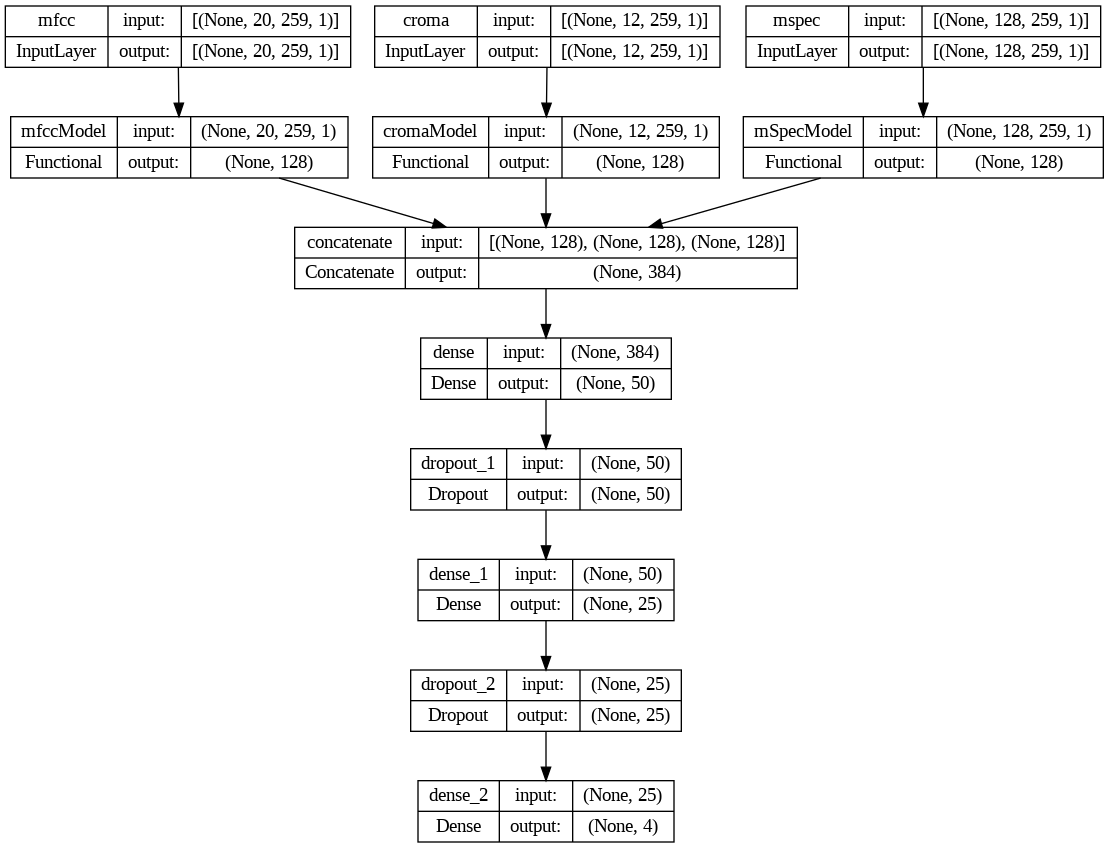

In [ ]:
#Heres and figure showing the model schematic
keras.utils.plot_model(net, "net.png", show_shapes=True)

In [ ]:
from keras import backend as K
net.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
K.set_value(net.optimizer.learning_rate, 0.001)

In [ ]:
#Training the Model
history=net.fit(
    {"mfcc":mfcc_train,"croma":cstft_train,"mspec":mSpec_train},
    ytrain,
    validation_data=({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval),
    epochs=100,verbose=0,
    callbacks=my_callbacks
)

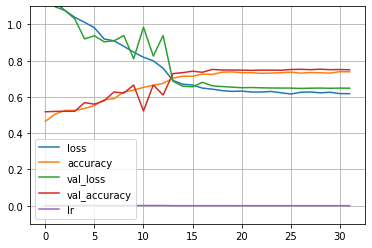

In [ ]:
#Plotting the various parameters
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1,1.1)
plt.show()

In [ ]:
net.evaluate({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval)

48/48 [==============================] - 0s 8ms/step - loss: 0.6484 - accuracy: 0.7500


[0.6484078764915466, 0.75]

In [ ]:
#saving the model for future use
net.save('/content/drive/MyDrive/Mosaic23/models/MosaicModel.h5')

#Loading Model

In [ ]:
reconstructed_model = keras.models.load_model("/content/drive/MyDrive/Mosaic23/models/MosaicModel.h5")

In [ ]:
path='/content/drive/MyDrive/Mosaic23/processed_audio_files/195_1b1_Ar_sc_Litt3200_0.wav'

In [ ]:
mfcc,cstft,mSpec,tempogram=[],[],[],[]


a,b,c=getFeatures(path)
mfcc.append(a)
cstft.append(b)
mSpec.append(c)
    
mfcc_test=np.array(mfcc)
cstft_test=np.array(cstft)
mSpec_test=np.array(mSpec)

In [ ]:
predictions=reconstructed_model.predict({"mfcc":mfcc_test,"croma":cstft_test,"mspec":mSpec_test})

1/1 [==============================] - 0s 396ms/step


In [ ]:
classes = np.argmax(predictions, axis = 1)
print(classes)

[3]


In [ ]:
def return_output(classes):
  if(classes[0]==0) :
    return 'both'
  if(classes[0]==1) :
    return 'crackles'
  if(classes[0]==2):
     return 'normal'
  if(classes[0]==3) :
    return 'weezels'

In [ ]:
print(return_output(classes))

weezels
